In [2]:
%cd ~/cdv/
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wat import wat
import rho_plus as rp

from eins import EinsOp, Reductions as R, Transformations as T

import treescope as ts
import treescope.figures as tsf

ts.basic_interactive_setup(autovisualize_arrays=False)

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


In [3]:
from pathlib import Path
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt

pretrained = True

if pretrained:
    run_dir = Path('logs') / 'enb-183'
    # run_dir = Path('logs') / '10-04-13-00_430'
    conf_file = run_dir / 'config.toml'
else:
    conf_file = 'configs/small.toml'

with open(conf_file) as f:
    config = pyrallis.cfgparsing.load(MainConfig, f)
    config.batch_size = 32

if not pretrained:    
    config.model.resid_init = 'ones'

# config.model.self_connection.mlp.dropout = 0.0
model = config.build_regressor()

In [6]:
from facet.data.dataset import load_file, dataloader

num_batches, dl = dataloader(config, 'train')
cg = jax.tree.map(lambda x: x[2], next(dl))
# cg

In [4]:
from facet.layers import Context

if pretrained:
    ckpt = best_ckpt(run_dir)
    params = ckpt['state']['params']
    ema_params = ckpt['state']['opt_state'][-1]['ema']['params']
else:
    out, params = model.init_with_output(jr.key(29205), cg=cg, ctx=Context(training=True))    
    ema_params = params

In [7]:
from flax import linen as nn
from dataclasses import dataclass
from treescope import rendering_parts as tsr

from typing import Sequence, Any
from facet.layers import Context, Identity
from facet.utils import debug_stat, debug_structure, flax_summary, intercept_stat, callable_name, signature
def add_with_duplicated_name(d: dict, k, v):
    prefix = 0
    while f'{prefix}_{k}' in d:
        prefix += 1
    d[f'{prefix}_{k}'] = v

class Params(dict):
    def __treescope_repr__(self, path, subtree_renderer):
        size = jax.tree.reduce(lambda x, y: x + y, jax.tree.map(lambda x: x.size, dict(self.items())), initializer=0)        

        children = []
        for k, v in self.items():
            child_path = None if path is None else f"{path}.{k}"
            children.append(tsr.build_full_line_with_annotations(
                tsr.siblings_with_annotations(
                    f"{k}: ",
                    subtree_renderer(v, path=child_path),
                )))
        return tsr.build_foldable_tree_node_from_children(
            prefix=tsr.text('Params{'),
            children=children,
            comma_separated=True,
            suffix='}',
            path=path,
            background_color='salmon',
            first_line_annotation=tsr.abbreviation_color(tsr.text(f'{size} parameters')),
            expand_state=tsr.ExpandState.COLLAPSED)
  


@dataclass
class ModuleCall:  
    module: nn.Module
    input: dict[str, Any]
    params: dict[str, Any]
    param_grads: dict[str, Any]
    children: dict[str, 'ModuleCall']
    output: Any

    def __treescope_repr__(self, path, subtree_renderer):
        attributes = {}
        if len(self.input):
            attributes['input'] = self.input

        if len(self.children):
            attributes['children'] = self.children

        if len(self.params):
            attributes['params'] = Params(**self.params)

        if len(self.param_grads):
            attributes['grads'] = Params(**self.param_grads)

        if self.output is not None:
            attributes['output'] = self.output
        

        children = []
        for k, v in attributes.items():
            child_path = None if path is None else f"{path}.{k}"
            children.append(tsr.build_full_line_with_annotations(
                tsr.siblings_with_annotations(
                    f"{k}: ",
                    subtree_renderer(v, path=child_path),
                )))
        return tsr.build_foldable_tree_node_from_children(
            prefix=tsr.siblings(tsr.maybe_qualified_type_name(type(self.module)), '('),
            children=[tsr.on_separate_lines(children)],
            suffix=')',
            path=path,
            comma_separated=True,
            first_line_annotation=tsr.abbreviation_color(tsr.text(self.module.name or "")),
            background_color=ts.formatting_util.color_from_string(str(type(self.module))),
            expand_state=tsr.ExpandState.COLLAPSED)
            
        # return ts.repr_lib.render_object_constructor(
        #     object_type=type(self.module),
        #     attributes=attributes,
        #     color=ts.formatting_util.color_from_string(str(type(self.module))),
        #     **kwargs
        # )
  

def insert(stack, call, path):
    if len(path) == 0:
        i = 0
        while f'{i}' in call.children:
            i += 1
        call.children[f'{i}'] = stack
        return call
    
    head, *tail = path
    if head in stack.children:
        stack.children[head] = insert(stack.children[head], call, tail)        
    else:
        stack.children[head] = call

    return stack


class FlowRecorder:
    def __init__(self):
        self.stack = None
        self.call_chain = []

    def __call__(self, next_fun, args, kwargs, context):        
        # print(self.call_chain)
        # print(type(context.module), context.module.path, context.method_name)
        if context.method_name == 'setup' or isinstance(context.module, Identity):
            return next_fun(*args, **kwargs)
        
        if context.method_name == '__call__':
            path = context.module.path
        else:
            *head, tail = context.module.path
            path = (*head, tail + '.' + context.method_name)

        if path:
            self.call_chain.append(path[-1])
        
        sig = signature(next_fun)
        bound = sig.bind(*args, **kwargs)              

        call = ModuleCall(
            context.module,
            {k: v for k, v in bound.arguments.items() if k != 'ctx'},
            {k: v for k, v in context.module.variables.get('params', {}).items() if not isinstance(v, dict)},
            {},
            {},
            None
        )

        if self.stack is None:
            self.stack = call
        else:
            self.stack = insert(self.stack, call, self.call_chain)

        out = context.orig_method(*args, **kwargs)
        call.output = out

        if path:
            self.call_chain.remove(path[-1])

        return out


rot_cg, rots = cg.rotate(314)
obj = FlowRecorder()
rng = jr.key(332)
ctx = Context(training=True)
mod_base = model.bind(params, rngs={'params': rng})
mod = model.bind({'params': ema_params}, rngs={'params': rng})
mod_apply = jax.jit(lambda cg: mod.apply(params, cg=cg, ctx=ctx, rngs=rng))
with nn.intercept_methods(obj):
    out = mod(cg=cg, ctx=ctx)

rot_out = mod(cg=rot_cg, ctx=ctx)
    
# base_out = mod_base(cg=cg, ctx=ctx)
# ts.display(obj.stack)

print(jnp.abs(out.reshape(-1) - cg.target_data.e_form.reshape(-1))[cg.padding_mask].mean())
print(jnp.abs(out - rot_out)[cg.padding_mask].reshape(-1).mean())

0.019417392
0.011017645


In [8]:
def apply(params):
    yhat = config.train.loss.efs_wrapper(model.apply, params, cg, ctx=Context(training=False))
    loss = config.train.loss.efs_loss(cg, yhat)
    return loss['loss'], (loss, yhat)


loss_out, (loss, yhat) = apply({'params': ema_params})
loss

# (loss_out, (efs_loss, yhat)), grads = jax.value_and_grad(apply, has_aux=True)(params)
# loss_out

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

{
    'energy': Array(0.0177329, dtype=float32),
    'force': Array(0.11407072, dtype=float32),
    'stress': Array(15.098988, dtype=float32),
    'loss': Array(0.0177329, dtype=float32)
}

In [9]:
# yhat = config.train.loss.efs_wrapper(model.apply, params, cg, ctx=ctx)
# if pretrained and config.data.dataset_name == 'mptrj':
#     fhat = R.l2_norm(yhat.force, -1)
#     f = R.l2_norm(cg.target_data.force, -1)
#     na = cg.n_node[cg.nodes.graph_i]

#     sns.scatterplot(x=fhat, y=f, ec=None, alpha=0.2, s=15)
#     plt.xlim(*plt.ylim())

#     plt.show()

#     dhat = jnp.linalg.det(yhat.stress)
#     d = jnp.linalg.det(cg.target_data.stress)

#     sns.scatterplot(x=dhat, y=d, ec=None, alpha=0.2, s=15)
#     plt.xlim(*plt.ylim())

In [10]:
# param_grad_leaves = list(zip(jax.tree.leaves(params), jax.tree.leaves(grads)))
# def insert_grads(stack: ModuleCall, param_grad_leaves):
#     for k, v in stack.params.items():
#         for a, b in param_grad_leaves:
#             if v.shape == a.shape and jnp.max(jnp.abs(v - a)) <= 1e-6:
#                 stack.param_grads[k] = b

#     for child in stack.children.values():
#         insert_grads(child, param_grad_leaves)

# insert_grads(obj.stack, param_grad_leaves)

In [11]:
import e3nn_jax as e3nn
from typing import Any
from flax import struct
from pymatgen.core import Element
from facet.utils import StatsVisitor, StructureVisitor, tree_traverse

elements = {
   z: Element.from_Z(z).symbol
   for z in range(1, 100)
}

md = mod.dataset_metadata
atom_nos = md.atomic_numbers

symbol_perm = np.argsort(atom_nos)
symbols = [Element.from_Z(z).symbol if z != 0 else '0' for z in sorted(atom_nos)]

colors = pd.read_csv('https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv')
jmol_palette = [(row['R'], row['G'], row['B']) for i, row in colors.iterrows()]

# x = e3nn.normal('128x0e + 64x1e + 32x2e', leading_shape=(32,))


if is_dark:
    div = rp.mpl_div_icefire_shift
else:
    div = rp.mpl_div_coolwarm_shift

ts.default_diverging_colormap.set_globally((255 * div(jnp.linspace(0, 1, 20))).tolist())

def render_tensor(arr, abbrev_color=None, **kwargs):    
    axis_item_labels = kwargs.get('axis_item_labels', {})    
    axis_labels = kwargs.get('axis_labels', {})
    for i, size in enumerate(arr.shape):
        if size == len(md.atomic_numbers):
            axis_labels[i] = 'species'
            axis_item_labels[i] = symbols
            arr = jnp.take(arr, symbol_perm, axis=i)
        elif size == (config.data.batch_n_nodes or md.batch_num_atoms * md.batch_num_graphs):
           node_mask = cg.padding_mask[cg.nodes.graph_i]
           new_shape = [1 for _ in range(i)] + [size] + [1 for _ in range(i + 1, len(arr.shape))]
           kwargs['valid_mask'] = node_mask.reshape(*new_shape)

    kwargs['axis_item_labels'] = axis_item_labels
    kwargs['axis_labels'] = axis_labels

    if arr.dtype == np.int16 and jnp.max(arr) <= 100:
       kwargs['value_item_labels'] = elements
       kwargs['colormap'] = ['grey', *jmol_palette]       
       arr = jnp.take(mod.dataset_metadata.atomic_numbers, arr)

    structure = tree_traverse(StructureVisitor(), arr)
    stats = tree_traverse(StatsVisitor(pad=False), arr)

    if abbrev_color is None:
       abbrev = lambda x: tsr.abbreviation_color(tsr.text(x))
    else:
       abbrev = lambda x: tsr.custom_text_color(tsr.text(x), abbrev_color)
    rendering = (
        tsr.build_custom_foldable_tree_node(
            label=abbrev(f'{structure} {stats}'),
            contents=tsr.siblings(
                tsr.fold_condition(
                    expanded=ts.lowering.maybe_defer_rendering(lambda _maybe_exp_state: tsr.siblings(
                        abbrev(":"),
                        tsr.indented_children([ts.render_array(
                            arr,
                            pixels_per_cell=5,
                            truncate=True,      
                            **kwargs,
                        ).treescope_part]),
                    ), placeholder_thunk=lambda: tsr.text("Rendering array..."))
                ),
                # abbrev(">"),
            ),
            expand_state=tsr.ExpandState.COLLAPSED,
        )
    )
        
    return rendering


def test_arrayviz(
    value: Any,
    path: tuple[Any, ...] | None,
):
  if isinstance(value, (np.ndarray, jax.Array)):
    return ts.VisualizationFromTreescopePart(render_tensor(value.squeeze()))

# ts.display(params['params']['node_embedding']['embed'], autovisualize=test_arrayviz)

In [12]:
def irrep_structure(arr: e3nn.IrrepsArray) -> str:
  arr_structure = tree_traverse(StructureVisitor(), arr.array[..., 0])
  return f'{arr_structure}[{arr.irreps}] :: '

def irrep_array_visualizer(
    value: Any,
    path: tuple[Any, ...] | None,
):
  if isinstance(value, (np.ndarray, jax.Array)):
    return ts.VisualizationFromTreescopePart(render_tensor(value.squeeze()))
  elif isinstance(value, e3nn.IrrepsArray):
    # abs_max = jnp.max(jnp.abs(value.array)).item()
    # vmin = -abs_max
    # vmax = abs_max

    visualizations = []
    for ir_mul, chunk in zip(value.irreps, value.chunks):      
      if chunk is None:
        continue

      chunk = chunk.squeeze()
      color = cs[ir_mul.ir.l]
      ndim = chunk.ndim
      kwargs = {
        'abbrev_color': color,
        # 'vmin': vmin,
        # 'vmax': vmax,
      }

      if ir_mul.ir.l == 0:
        kwargs['arr'] = chunk
      else:
        kwargs['arr'] = chunk
        kwargs['rows'] = [ndim - 1]
        kwargs['sliders'] = list(range(0, ndim-2))
        kwargs['axis_labels'] = {(ndim-1): str(ir_mul.ir)}
        
      visualizations.append(render_tensor(**kwargs).renderable)
    return ts.VisualizationFromTreescopePart(tsr.build_custom_foldable_tree_node(
      label=tsr.abbreviation_color(tsr.text(irrep_structure(value))), 
      contents=tsr.indented_children(visualizations, comma_separated=True), 
      path=path, 
      expand_state=tsr.ExpandState.EXPANDED))
  
  

# ts.display(obj.stack.children['mace'].children['layer_0'].output, autovisualize=irrep_array_visualizer)

In [ ]:
ts.display(obj.stack, autovisualize=irrep_array_visualizer)

<IPython.core.display.HTML object>

<Axes: >

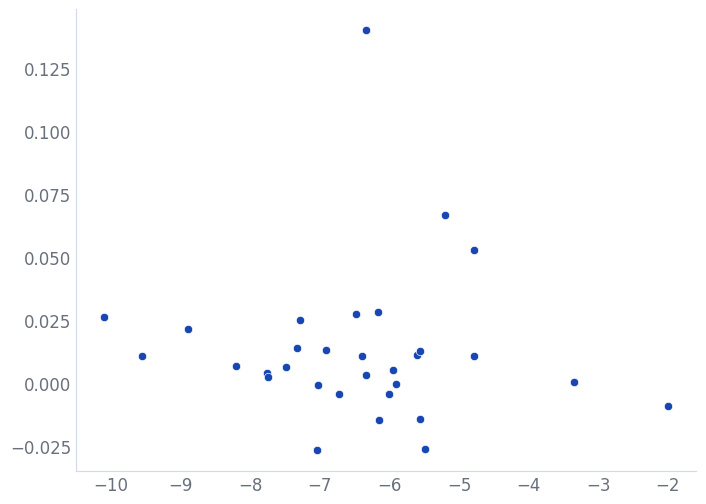

In [13]:
y = cg.target_data.e_form[cg.padding_mask]
yhat = obj.stack.output.reshape(-1)[cg.padding_mask]
sns.scatterplot(x=y, y=y-yhat)
# sns.scatterplot(x=cg.target_data.e_form[cg.padding_mask], y=obj.stack.output.reshape(-1)[cg.padding_mask])

In [14]:
with open('reports/facet-small.html', 'w') as f:
    with ts.active_autovisualizer.set_scoped(irrep_array_visualizer):
        f.write(ts.render_to_html(obj.stack, compressed=False))

In [12]:
from facet.utils import save_pytree


# save_pytree(ema_params, 'precomputed/enb-195.ckpt')